## Intro

In recent years, Generative Adversarial Networks (GANs) have emerged as a powerful class of machine learning models capable of generating realistic synthetic data. This implementation focuses on training a GAN to generate handwritten digits similar to those found in the MNIST dataset, which consists of 70,000 grayscale images of handwritten digits from 0 to 9. The GAN architecture consists of two neural networks: a generator that creates fake images from random noise and a discriminator that evaluates the authenticity of the images. The generator aims to produce images that are indistinguishable from real ones, while the discriminator strives to correctly classify images as real or fake. Through adversarial training, both networks improve over time, leading to the generation of high-quality images. This code provides a foundational understanding of GANs and serves as a practical example of their application in image generation.

In [2]:
#pip install tensorflow

2025-05-15 15:43:12.522477: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 


/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.7033, acc.: 45.90%] [G loss: 0.6875]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


OSError: [Errno 30] Read-only file system: 'gan_generated_epoch_0.png'

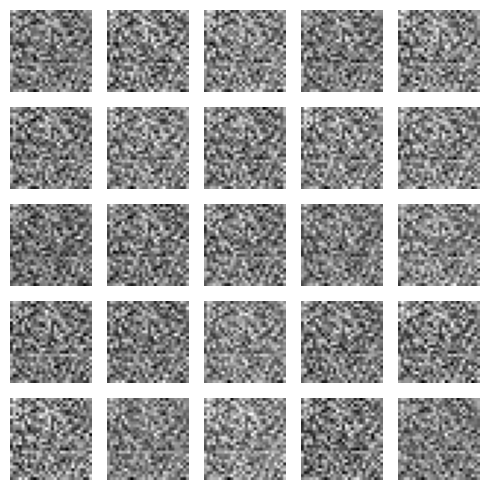

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

# Load the MNIST dataset
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype('float32') / 255.0  # Normalize the images to [0, 1]
X_train = np.expand_dims(X_train, axis=-1)  # Add a channel dimension

# Set parameters
latent_dim = 100  # Dimension of the noise vector
num_epochs = 10000  # Number of training epochs
batch_size = 128  # Batch size

# Build the generator model
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, activation='relu', input_dim=latent_dim))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(28 * 28 * 1, activation='tanh'))  # Output shape (28, 28, 1)
    model.add(layers.Reshape((28, 28, 1)))
    return model

# Build the discriminator model
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 1)))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Output a probability
    return model

# Create the GAN model
generator = build_generator()
discriminator = build_discriminator()

# Compile the discriminator
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Create the GAN model
discriminator.trainable = False  # Freeze the discriminator when training the GAN
gan_input = layers.Input(shape=(latent_dim,))
fake_image = generator(gan_input)
gan_output = discriminator(fake_image)
gan = tf.keras.Model(gan_input, gan_output)

# Compile the GAN model
gan.compile(loss='binary_crossentropy', optimizer='adam')

# Function to train the GAN
def train_gan(epochs, batch_size):
    for epoch in range(epochs):
        # Train the discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_images = generator.predict(noise)

        # Labels for real and fake images
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_labels = np.ones((batch_size, 1))  # Labels for the generator
        g_loss = gan.train_on_batch(noise, valid_labels)

        # Print the progress
        if epoch % 1000 == 0:
            print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc.: {100 * d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")
            # Generate and save images
            generate_and_save_images(epoch)

# Function to generate and save images
def generate_and_save_images(epoch):
    noise = np.random.normal(0, 1, (25, latent_dim))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5  # Rescale to [0, 1]

    plt.figure(figsize=(5, 5))
    for i in range(generated_images.shape[0]):
        plt.subplot(5, 5, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"gan_generated_epoch_{epoch}.png")
    plt.close()

# Start training the GAN
train_gan(num_epochs, batch_size)


### Conclusion

In conclusion, this implementation of a Generative Adversarial Network demonstrates the fundamental principles of adversarial training and showcases the ability of GANs to generate realistic images. By leveraging the MNIST dataset, we have successfully trained a generator to produce synthetic handwritten digits that closely resemble the original data. The training process involves a delicate balance between the generator and discriminator, where both networks continuously improve through competition. While this example serves as a starting point for understanding GANs, there are numerous avenues for further exploration, including experimenting with different architectures, hyperparameters, and advanced techniques such as conditional GANs or progressive growing GANs. As GANs continue to evolve, they hold great potential for various applications, including image synthesis, data augmentation, and creative content generation.
